semetic feature extraction https://colab.research.google.com/drive/1Vl5YQbDJ8jQGzvLU476mYeGiV-ZUE5NS#scrollTo=pMBi4uWC55Fq
semetic processing  : https://colab.research.google.com/drive/1PXvvB7Sc3Pg5ZnsG8QlaWhN5pQod2EA0#scrollTo=qEV8EoGbIba7

Sentiment results : https://drive.google.com/drive/folders/1TXvbvZfETEyu3njo9UuKNHSz0BUBOMX3?usp=sharing

Lang Model results : https://drive.google.com/drive/folders/1YE3Kk-qG0o1YOUW3y0XCVBo6Wm-apHTw?usp=sharing

### def func

In [1]:
def compute_metrics(pred,ground_labels):
    labels_all = ground_labels
    preds_all = list(pred)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, preds_all)
    acc = accuracy_score(labels_all, preds_all)
    confusion_mat = confusion_matrix(labels_all, preds_all)
    # tn, fp, fn, tp = confusiton_mat.ravel()
    out_dict = {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusiton_mat': confusion_mat
    }
    return out_dict

### import Lib

In [2]:
import torch
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_fscore_support, \
    confusion_matrix
from sklearn.svm import SVC
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

### Read sementic

In [7]:
dfLiarSementic = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/Liar_sementic.csv")
# dfLiar["label"]=dfLiar["label"].replace(["true","mostly-true"],0)
# dfLiar["label"]=dfLiar["label"].replace(["half-true","false","barely-true","pants-fire"],1)

In [8]:
dfLiarSementic.head()

,ID,label,split,url_count,qn_symbol,num_chars,num_words,num_sentences,words_per_sentence,characters_per_word,punctuations_per_sentence,positive,negative,num_exclamation,get_sentiment_polarity,lexical_diversity,content_word_diversity_and_redundancy,nvaa,content_word_diversity,redundancy,noun,verb,adj,adv,lang
0,11972.json,true,test,0,0,68,11,1,11.0,5.181818,4.0,0.000000,0.000000,0,0.0000,100.000000,"{'content_word_diversity': 54.54545454545454, ...","{'NOUN': 27.27272727272727, 'VERB': 27.2727272...",54.545455,45.454545,27.272727,27.272727,0.000000,9.090909,en
1,11685.json,false,test,0,0,63,12,1,12.0,4.250000,1.0,0.000000,0.000000,0,0.0772,100.000000,"{'content_word_diversity': 50.0, 'redundancy':...","{'NOUN': 33.33333333333333, 'VERB': 8.33333333...",50.000000,50.000000,33.333333,8.333333,0.000000,0.000000,en
2,11096.json,false,test,0,0,51,10,1,10.0,4.100000,1.0,0.000000,0.000000,0,-0.3089,100.000000,"{'content_word_diversity': 50.0, 'redundancy':...","{'NOUN': 10.0, 'VERB': 30.0, 'ADJ': 0.0, 'ADV'...",50.000000,50.000000,10.000000,30.000000,0.000000,0.000000,en
3,5209.json,half-true,test,0,0,85,13,1,13.0,5.538462,1.0,7.692308,0.000000,0,0.3400,100.000000,"{'content_word_diversity': 69.23076923076923, ...","{'NOUN': 23.076923076923077, 'VERB': 23.076923...",69.230769,30.769231,23.076923,23.076923,0.000000,0.000000,en
4,9524.json,pants-fire,test,0,0,127,23,2,11.5,4.434783,1.5,0.000000,8.695652,0,-0.5994,95.652174,"{'content_word_diversity': 60.86956521739131, ...","{'NOUN': 21.73913043478261, 'VERB': 17.3913043...",60.869565,39.130435,21.739130,17.391304,4.347826,4.347826,en


### Read sentiment

In [9]:
dfLiarSentiment = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/LIAR_predictions_emotions.csv")

In [10]:
dfLiarSentiment.head()

,label,text,ID,split,index,emotion_score_dict,highest_eight_label,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,true,building a wall on the u s mexico border will ...,11972.json,test,0,"{'surprise': 0.0, 'disgust': 0.0, 'sadness': 0...",anticipation,0.280,1.344,0.000,0.209,0.267,0.083,0.000,0.663
1,false,wisconsin is on pace to double the number of l...,11685.json,test,1,"{'sadness': 0.0, 'disgust': 0.045, 'surprise':...",anticipation,0.273,0.913,0.045,0.213,0.518,0.000,0.200,0.489
2,false,says john mccain has done nothing to help the ...,11096.json,test,2,"{'anticipation': 0.0, 'trust': 0.063, 'surpris...",anger,1.059,0.000,0.537,0.182,0.203,0.840,0.088,0.063
3,half-true,suzanne bonamici supports a plan that will cut...,5209.json,test,3,"{'disgust': 0.023, 'surprise': 0.045, 'fear': ...",trust,0.421,0.210,0.023,0.159,0.217,0.448,0.045,0.774
4,pants-fire,when asked by a reporter whether hes at the ce...,9524.json,test,4,"{'anticipation': 0.0, 'disgust': 0.016, 'surpr...",trust,0.128,0.000,0.016,0.057,0.156,0.114,0.044,0.804


In [11]:
# dftest = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Results/LIAR/final_predictions_emotions_LIAR_test.csv")
# dftest["split"]="test"

# dftrain = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Results/LIAR/final_predictions_emotions_LIAR_train.csv" )
# dftrain["split"]="train"
# df=dftest.append(dftrain,ignore_index = True)

# dfvalid = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Results/LIAR/final_predictions_emotions_LIAR_valid.csv" )
# dfvalid["split"]="valid"
# dfLiarSentiment=df.append(dfvalid,ignore_index = True)

### read lexicon

In [12]:
dfLiarLexicon = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/Liar_lexicon.csv")

In [13]:
dfLiarLexicon.head()

,ID,fake_score,true_score,common_score
0,11972.json,1801.728588,2867.965230,2309.097930
1,11685.json,1636.442135,2611.149300,2129.708994
2,11096.json,2175.136997,2905.530664,2529.158112
3,5209.json,1529.073267,2379.133609,1960.431751
4,9524.json,761.657251,939.796419,826.132223


In [ ]:
# dftest = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/ghanashyamvtatti roberta-fake-news/LIAR_Results/LIAR_lexicon_results_test_normalized.csv")
# # dftest = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/ghanashyamvtatti roberta-fake-news/LIAR_Results/LIAR_lexicon_results_test.csv")
# dftest["split"]="test"

# dftrain = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/ghanashyamvtatti roberta-fake-news/LIAR_Results/LIAR_lexicon_results_train_normalized.csv" )
# # dftrain = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/ghanashyamvtatti roberta-fake-news/LIAR_Results/LIAR_lexicon_results_train.csv" )
# dftrain["split"]="train"
# df=dftest.append(dftrain,ignore_index = True)

# dfvalid = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/ghanashyamvtatti roberta-fake-news/LIAR_Results/LIAR_lexicon_results_valid_normalized.csv" )
# # dfvalid = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/ghanashyamvtatti roberta-fake-news/LIAR_Results/LIAR_lexicon_results_valid.csv")
# dfvalid["split"]="valid"
# dfLiarLangMod=df.append(dfvalid,ignore_index = True)

In [ ]:
# dfWelfake = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/WelFake_predictions_emotions_lexicon.csv")
# dfWelfake=dfWelfake.drop(dfWelfake.columns[dfWelfake.columns.str.contains('unnamed',case = False)],axis = 1)

# dfWelfake["qn_symbol_per_sentence"]=dfWelfake["qn_symbol"]/dfWelfake["num_sentences"]
# dfWelfake["num_exclamation_per_sentence"]=dfWelfake["num_exclamation"]/dfWelfake["num_sentences"]
# dfWelfake["url_count_per_sentence"]=dfWelfake["url_count"]/dfWelfake["num_sentences"]

In [ ]:
# dfWelfake.head()

In [14]:
dff=dfLiarSentiment.merge(dfLiarSementic, how='inner', on='ID',suffixes=('_Sentiment', '_Sementic'))

In [15]:
df=dff.merge(dfLiarLexicon, how='inner', on='ID',suffixes=('', '_Lexicon'))

In [16]:
df=df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)

In [17]:
df["qn_symbol_per_sentence"]=df["qn_symbol"]/df["num_sentences"]
df["num_exclamation_per_sentence"]=df["num_exclamation"]/df["num_sentences"]
df["url_count_per_sentence"]=df["url_count"]/df["num_sentences"]

In [18]:
df.head()

,label_Sentiment,text,ID,split_Sentiment,index,emotion_score_dict,highest_eight_label,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,label_Sementic,split_Sementic,url_count,qn_symbol,num_chars,num_words,num_sentences,words_per_sentence,characters_per_word,punctuations_per_sentence,positive,negative,num_exclamation,get_sentiment_polarity,lexical_diversity,content_word_diversity_and_redundancy,nvaa,content_word_diversity,redundancy,noun,verb,adj,adv,lang,fake_score,true_score,common_score,qn_symbol_per_sentence,num_exclamation_per_sentence,url_count_per_sentence
0,true,building a wall on the u s mexico border will ...,11972.json,test,0,"{'surprise': 0.0, 'disgust': 0.0, 'sadness': 0...",anticipation,0.280,1.344,0.000,0.209,0.267,0.083,0.000,0.663,true,test,0,0,68,11,1,11.0,5.181818,4.0,0.000000,0.000000,0,0.0000,100.000000,"{'content_word_diversity': 54.54545454545454, ...","{'NOUN': 27.27272727272727, 'VERB': 27.2727272...",54.545455,45.454545,27.272727,27.272727,0.000000,9.090909,en,1801.728588,2867.965230,2309.097930,0.0,0.0,0.0
1,false,wisconsin is on pace to double the number of l...,11685.json,test,1,"{'sadness': 0.0, 'disgust': 0.045, 'surprise':...",anticipation,0.273,0.913,0.045,0.213,0.518,0.000,0.200,0.489,false,test,0,0,63,12,1,12.0,4.250000,1.0,0.000000,0.000000,0,0.0772,100.000000,"{'content_word_diversity': 50.0, 'redundancy':...","{'NOUN': 33.33333333333333, 'VERB': 8.33333333...",50.000000,50.000000,33.333333,8.333333,0.000000,0.000000,en,1636.442135,2611.149300,2129.708994,0.0,0.0,0.0
2,false,says john mccain has done nothing to help the ...,11096.json,test,2,"{'anticipation': 0.0, 'trust': 0.063, 'surpris...",anger,1.059,0.000,0.537,0.182,0.203,0.840,0.088,0.063,false,test,0,0,51,10,1,10.0,4.100000,1.0,0.000000,0.000000,0,-0.3089,100.000000,"{'content_word_diversity': 50.0, 'redundancy':...","{'NOUN': 10.0, 'VERB': 30.0, 'ADJ': 0.0, 'ADV'...",50.000000,50.000000,10.000000,30.000000,0.000000,0.000000,en,2175.136997,2905.530664,2529.158112,0.0,0.0,0.0
3,half-true,suzanne bonamici supports a plan that will cut...,5209.json,test,3,"{'disgust': 0.023, 'surprise': 0.045, 'fear': ...",trust,0.421,0.210,0.023,0.159,0.217,0.448,0.045,0.774,half-true,test,0,0,85,13,1,13.0,5.538462,1.0,7.692308,0.000000,0,0.3400,100.000000,"{'content_word_diversity': 69.23076923076923, ...","{'NOUN': 23.076923076923077, 'VERB': 23.076923...",69.230769,30.769231,23.076923,23.076923,0.000000,0.000000,en,1529.073267,2379.133609,1960.431751,0.0,0.0,0.0
4,pants-fire,when asked by a reporter whether hes at the ce...,9524.json,test,4,"{'anticipation': 0.0, 'disgust': 0.016, 'surpr...",trust,0.128,0.000,0.016,0.057,0.156,0.114,0.044,0.804,pants-fire,test,0,0,127,23,2,11.5,4.434783,1.5,0.000000,8.695652,0,-0.5994,95.652174,"{'content_word_diversity': 60.86956521739131, ...","{'NOUN': 21.73913043478261, 'VERB': 17.3913043...",60.869565,39.130435,21.739130,17.391304,4.347826,4.347826,en,761.657251,939.796419,826.132223,0.0,0.0,0.0


In [19]:
sementic_features= ['url_count',
                    'qn_symbol',
                    'num_chars',
                    'num_words',
                    'num_sentences',
                    'words_per_sentence',
                    'characters_per_word',
                    'punctuations_per_sentence',
                    'num_exclamation',
                    'get_sentiment_polarity',
                    'lexical_diversity',
                    'content_word_diversity',
                    'redundancy',
                    'noun',
                    'verb',
                    'adj',
                    'adv',
                    "qn_symbol_per_sentence",
                    "num_exclamation_per_sentence",
                    "url_count_per_sentence"
                    ]
LangMod_Features=   ['fake_score', 
                    'true_score', 
                    'common_score']

Sentiment_features= ['highest_eight_label', 
                    'anger', 
                    'anticipation',
                    'disgust', 
                    'fear',
                    'joy', 
                    'sadness', 
                    'surprise', 
                    'trust']
All_features=sementic_features+LangMod_Features+Sentiment_features
All_features.remove("highest_eight_label")

In [20]:
df.loc[df["lang"]!="en"].shape

(81, 45)

In [21]:
df=df.loc[df["lang"]=="en"]

In [23]:
df["label"]=df["label_Sentiment"]

In [24]:
# df["label"]=df["label"].replace(["true","mostly-true"],0)
# df["label"]=df["label"].replace(["half-true","false","barely-true","pants-fire"],1)
df["label"]=df["label"].replace(["true"],0)
df["label"]=df["label"].replace(["half-true","false","barely-true","pants-fire","mostly-true"],1)

In [25]:
df[All_features+["label","ID","split_Sentiment"]].head()

,url_count,qn_symbol,num_chars,num_words,num_sentences,words_per_sentence,characters_per_word,punctuations_per_sentence,num_exclamation,get_sentiment_polarity,lexical_diversity,content_word_diversity,redundancy,noun,verb,adj,adv,qn_symbol_per_sentence,num_exclamation_per_sentence,url_count_per_sentence,fake_score,true_score,common_score,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,label,ID,split_Sentiment
0,0,0,68,11,1,11.0,5.181818,4.0,0,0.0000,100.000000,54.545455,45.454545,27.272727,27.272727,0.000000,9.090909,0.0,0.0,0.0,1801.728588,2867.965230,2309.097930,0.280,1.344,0.000,0.209,0.267,0.083,0.000,0.663,0,11972.json,test
1,0,0,63,12,1,12.0,4.250000,1.0,0,0.0772,100.000000,50.000000,50.000000,33.333333,8.333333,0.000000,0.000000,0.0,0.0,0.0,1636.442135,2611.149300,2129.708994,0.273,0.913,0.045,0.213,0.518,0.000,0.200,0.489,1,11685.json,test
2,0,0,51,10,1,10.0,4.100000,1.0,0,-0.3089,100.000000,50.000000,50.000000,10.000000,30.000000,0.000000,0.000000,0.0,0.0,0.0,2175.136997,2905.530664,2529.158112,1.059,0.000,0.537,0.182,0.203,0.840,0.088,0.063,1,11096.json,test
3,0,0,85,13,1,13.0,5.538462,1.0,0,0.3400,100.000000,69.230769,30.769231,23.076923,23.076923,0.000000,0.000000,0.0,0.0,0.0,1529.073267,2379.133609,1960.431751,0.421,0.210,0.023,0.159,0.217,0.448,0.045,0.774,1,5209.json,test
4,0,0,127,23,2,11.5,4.434783,1.5,0,-0.5994,95.652174,60.869565,39.130435,21.739130,17.391304,4.347826,4.347826,0.0,0.0,0.0,761.657251,939.796419,826.132223,0.128,0.000,0.016,0.057,0.156,0.114,0.044,0.804,1,9524.json,test


In [26]:
df=df[All_features+["label","ID","split_Sentiment"]]

## Put H20 code here

In [ ]:
df.split_Sentiment.value_counts()

train    10150
valid     1271
test      1263
Name: split_Sentiment, dtype: int64

In [ ]:
dfTrain=df.loc[df["split_Sentiment"]=="train"]
dfTest=df.loc[df["split_Sentiment"]=="test"]
dfValid=df.loc[df["split_Sentiment"]=="valid"]

In [ ]:
dfValid.shape

(1271, 34)

In [ ]:
dfValid.head()

,url_count,qn_symbol,num_chars,num_words,num_sentences,words_per_sentence,characters_per_word,punctuations_per_sentence,num_exclamation,get_sentiment_polarity,lexical_diversity,content_word_diversity,redundancy,noun,verb,adj,adv,qn_symbol_per_sentence,num_exclamation_per_sentence,url_count_per_sentence,fake_score,true_score,common_score,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,label,ID,split_Sentiment
11486,0,0,51,10,1,10.0,4.100000,1.0,0,0.0000,100.000000,30.000000,70.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0,0.0,1705.717399,1581.677111,1617.575418,0.683,0.000,0.260,0.470,0.404,0.739,0.000,0.197,barely-true,12134.json,valid
11487,0,0,148,26,1,26.0,4.500000,6.0,0,0.0000,88.461538,42.307692,46.153846,11.538462,11.538462,3.846154,15.384615,0.0,0.0,0.0,712.497288,1144.814966,922.615536,0.165,0.041,0.026,0.139,0.103,0.057,0.063,0.522,pants-fire,238.json,valid
11488,0,0,204,32,1,32.0,5.375000,1.0,0,-0.3400,90.625000,46.875000,43.750000,18.750000,18.750000,6.250000,12.500000,0.0,0.0,0.0,581.392050,838.721324,700.985057,0.150,0.066,0.038,0.175,0.138,0.011,0.067,0.261,false,7891.json,valid
11489,0,0,46,8,1,8.0,4.750000,1.0,0,-0.4767,100.000000,75.000000,25.000000,37.500000,12.500000,12.500000,12.500000,0.0,0.0,0.0,2583.567751,3780.813936,3180.397008,0.465,0.000,0.941,0.345,0.171,2.260,0.086,0.067,half-true,8169.json,valid
11490,0,0,190,33,1,33.0,4.636364,5.0,0,-0.4404,93.939394,42.424242,51.515152,21.212121,6.060606,15.151515,0.000000,0.0,0.0,0.0,561.666788,861.742298,707.850249,0.343,0.014,0.077,0.056,0.109,0.198,0.080,0.102,half-true,929.json,valid


## visualize

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


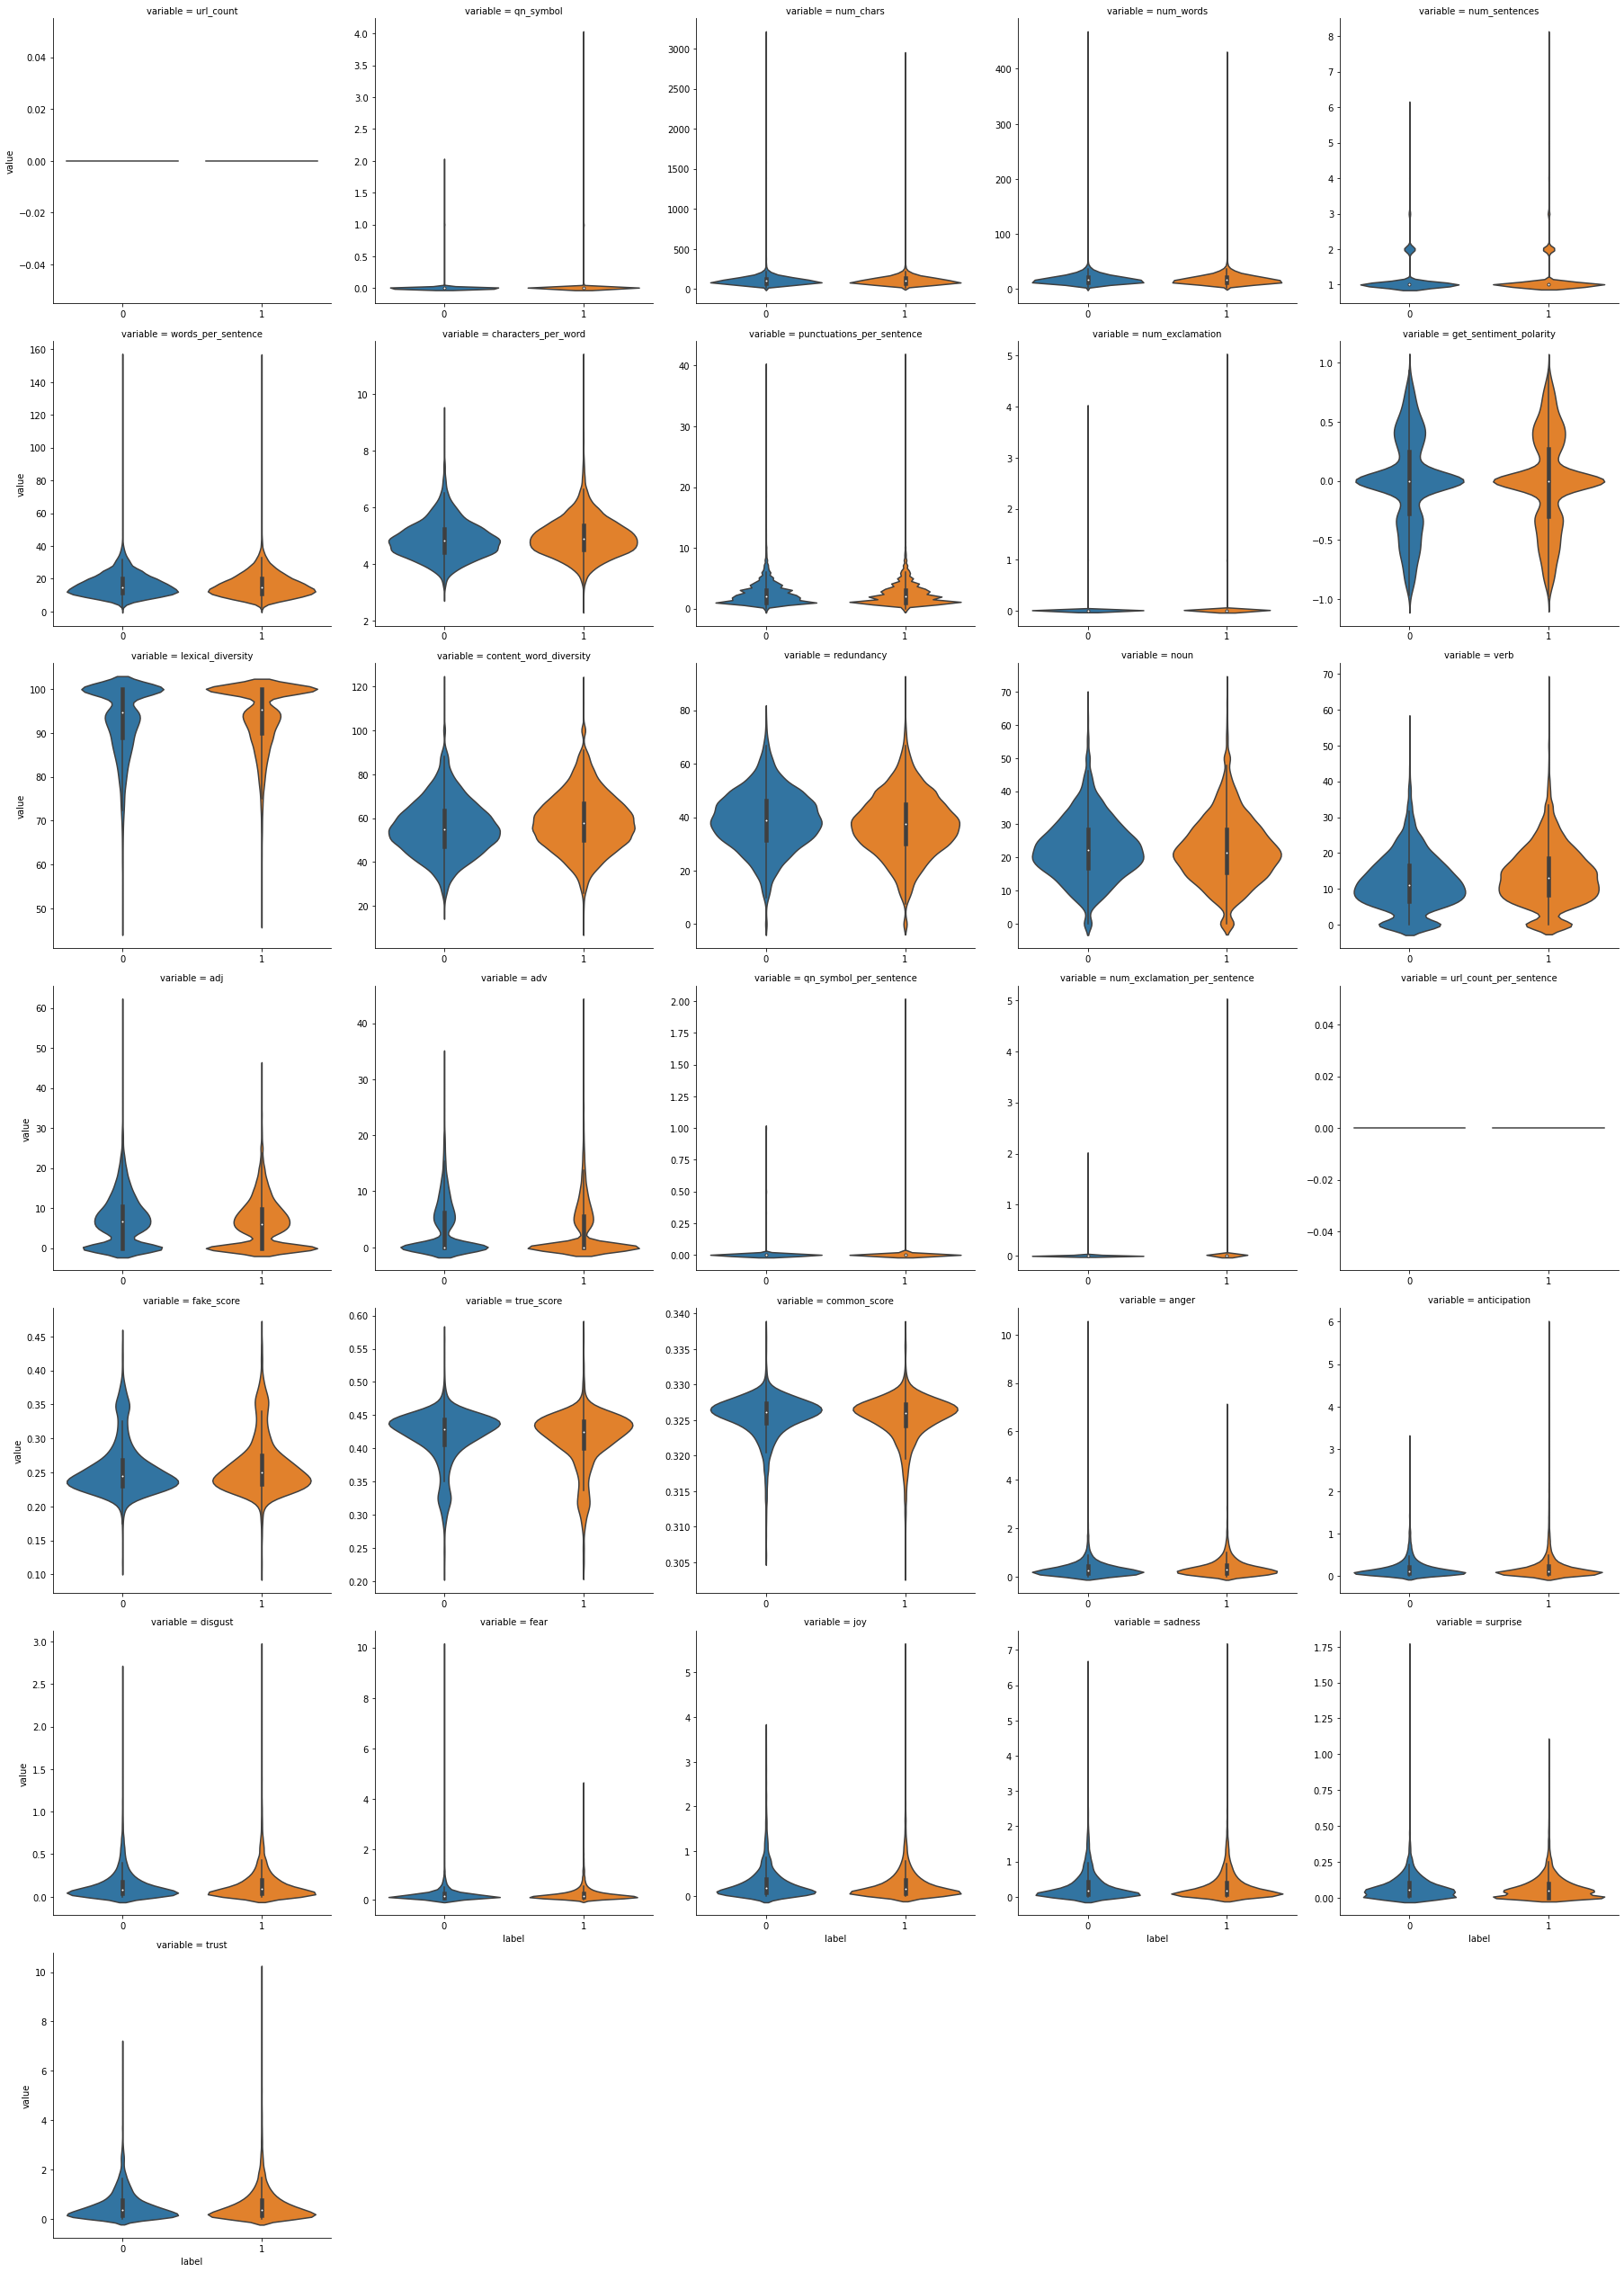

In [ ]:
f = pd.melt( df, id_vars='label', value_vars=All_features)

g = sns.catplot(x="label" ,y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);

In [ ]:
df.loc[df.url_count>0]

,ID,label,statement,emotion_score_dict,highest_eight_label,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,split_Sentiment,fake_score,true_score,common_score,split_LangMod,url_count,qn_symbol,num_chars,num_words,num_sentences,words_per_sentence,characters_per_word,punctuations_per_sentence,num_exclamation,get_sentiment_polarity,lexical_diversity,content_word_diversity,redundancy,noun,verb,adj,adv,text,label_Sementic,source,split,lang,qn_symbol_per_sentence,num_exclamation_per_sentence,url_count_per_sentence


In [29]:
X=df[All_features]
Y=df.label

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

## feature analysis liar 2:4  sementic +sentiment + lang MOd

In [ ]:
All_features

['url_count',
 'qn_symbol',
 'num_chars',
 'num_words',
 'num_sentences',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'num_exclamation',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence',
 'url_count_per_sentence',
 'fake_score',
 'true_score',
 'common_score',
 'anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust']

In [ ]:
X.head()

,url_count,qn_symbol,num_chars,num_words,num_sentences,words_per_sentence,characters_per_word,punctuations_per_sentence,num_exclamation,get_sentiment_polarity,lexical_diversity,content_word_diversity,redundancy,noun,verb,adj,adv,qn_symbol_per_sentence,num_exclamation_per_sentence,url_count_per_sentence,fake_score,true_score,common_score,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,0,0,68,11,1,11.0,5.181818,4.0,0,0.0000,100.000000,54.545455,45.454545,27.272727,27.272727,0.000000,9.090909,0.0,0.0,0.0,0.235825,0.438748,0.325427,0.338,1.082,0.038,0.105,0.290,0.092,0.076,0.537
1,0,0,63,12,1,12.0,4.250000,1.0,0,0.0772,100.000000,50.000000,50.000000,33.333333,8.333333,0.000000,0.000000,0.0,0.0,0.0,0.236122,0.440617,0.323261,0.037,0.958,0.000,0.186,0.864,0.000,0.065,0.539
2,0,0,51,10,1,10.0,4.100000,1.0,0,-0.3089,100.000000,50.000000,50.000000,10.000000,30.000000,0.000000,0.000000,0.0,0.0,0.0,0.298905,0.380127,0.320967,0.885,0.000,0.448,0.156,0.080,1.107,0.074,0.152
3,0,0,85,13,1,13.0,5.538462,1.0,0,0.3400,100.000000,69.230769,30.769231,23.076923,23.076923,0.000000,0.000000,0.0,0.0,0.0,0.251828,0.422031,0.326141,0.425,0.157,0.054,0.204,0.162,0.279,0.010,0.965
4,0,0,127,23,2,11.5,4.434783,1.5,0,-0.5994,95.652174,60.869565,39.130435,21.739130,17.391304,4.347826,4.347826,0.0,0.0,0.0,0.238641,0.436970,0.324389,0.139,0.072,0.025,0.019,0.053,0.073,0.000,1.020


In [ ]:
Y.value_counts()

1    8205
0    4481
Name: label, dtype: int64

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 24


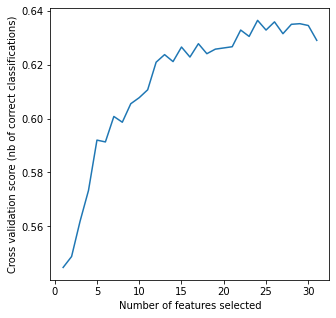

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.grid_scores_

array([0.54470721, 0.54876126, 0.56182432, 0.57331081, 0.5920045 ,
       0.59132883, 0.60078829, 0.59864865, 0.60551802, 0.60777027,
       0.6106982 , 0.62094595, 0.62376126, 0.62117117, 0.62657658,
       0.62286036, 0.62781532, 0.6240991 , 0.62578829, 0.62623874,
       0.62668919, 0.63288288, 0.63051802, 0.63648649, 0.63288288,
       0.63592342, 0.63153153, 0.63502252, 0.63524775, 0.63457207,
       0.62905405])

In [ ]:
rfecv.support_

array([False, False,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [ ]:
rfecv.ranking_

array([8, 4, 1, 1, 2, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 3, 5, 7, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
print(X_train.columns.values[rfecv.support_])

['num_chars' 'num_words' 'words_per_sentence' 'characters_per_word'
 'punctuations_per_sentence' 'get_sentiment_polarity' 'lexical_diversity'
 'content_word_diversity' 'redundancy' 'noun' 'verb' 'adj' 'adv'
 'fake_score' 'true_score' 'common_score' 'anger' 'anticipation' 'disgust'
 'fear' 'joy' 'sadness' 'surprise' 'trust']


In [ ]:
rfecv.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [ ]:
rfecv_features

['num_chars',
 'num_words',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv',
 'fake_score',
 'true_score',
 'common_score',
 'anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust']

In [ ]:
len(rfecv_features)

24

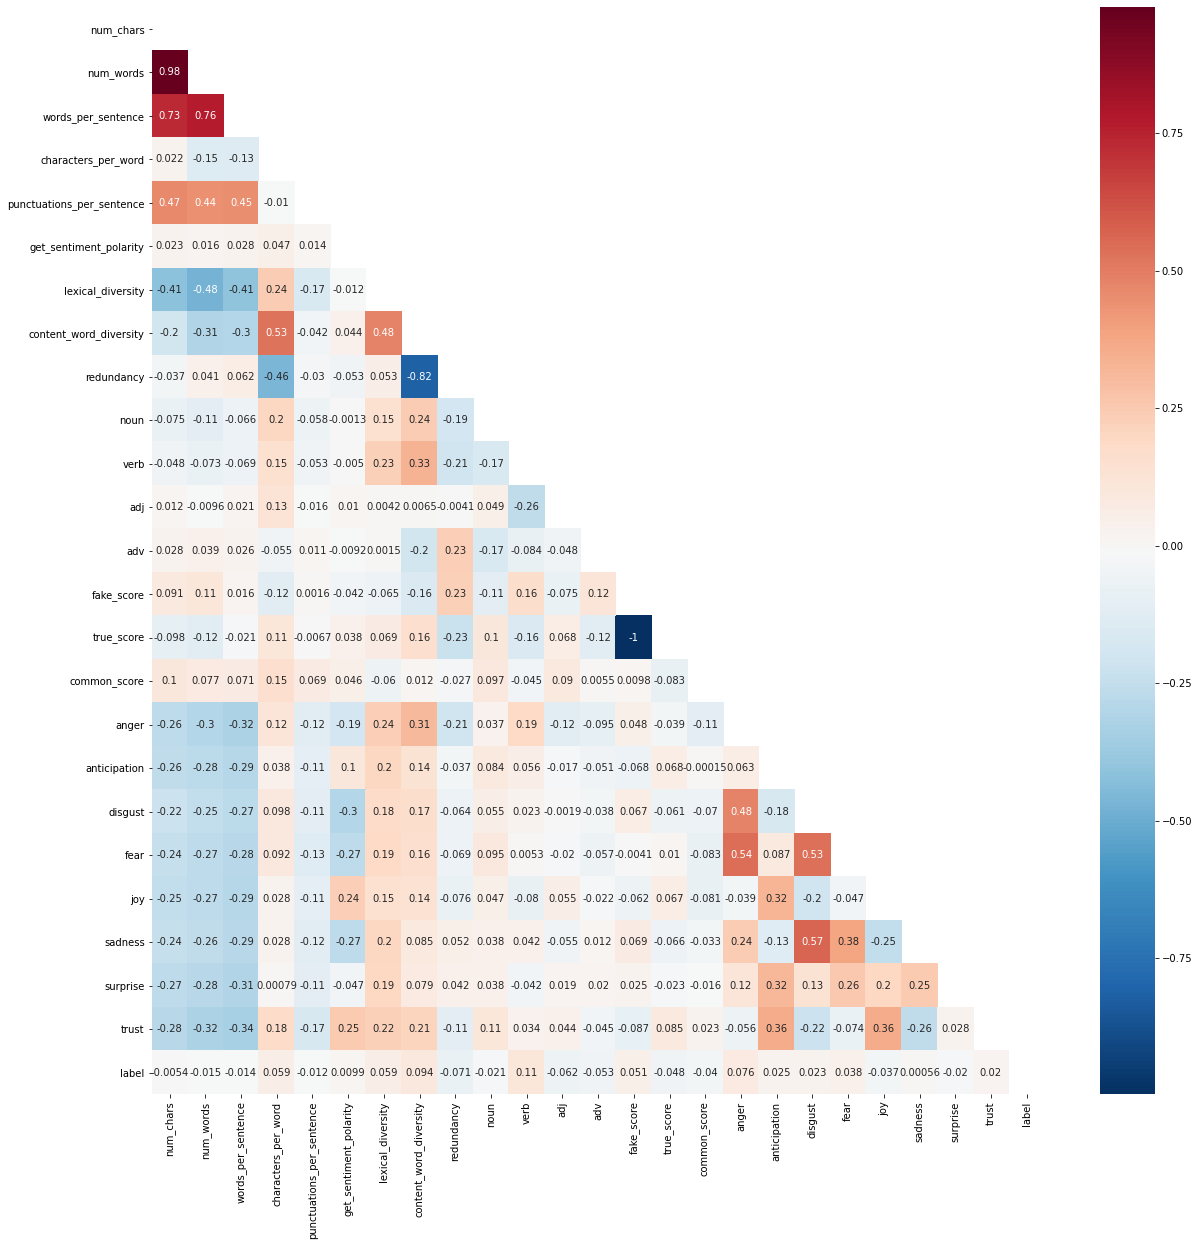

In [ ]:
# mask out upper triangle
mask = np.zeros_like(df[rfecv_features+["label"]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(df[rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
# tn, fp, fn, tp = 0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.487	0.684	0.298	0.829	0.369	0.749	0.641	400	944	422	2040


## feature analysis liar 1:5  sementic +sentiment + lang MOd

In [27]:
All_features

['url_count',
 'qn_symbol',
 'num_chars',
 'num_words',
 'num_sentences',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'num_exclamation',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence',
 'url_count_per_sentence',
 'fake_score',
 'true_score',
 'common_score',
 'anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust']

In [31]:
X.head()

,url_count,qn_symbol,num_chars,num_words,num_sentences,words_per_sentence,characters_per_word,punctuations_per_sentence,num_exclamation,get_sentiment_polarity,lexical_diversity,content_word_diversity,redundancy,noun,verb,adj,adv,qn_symbol_per_sentence,num_exclamation_per_sentence,url_count_per_sentence,fake_score,true_score,common_score,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,0,0,68,11,1,11.0,5.181818,4.0,0,0.0000,100.000000,54.545455,45.454545,27.272727,27.272727,0.000000,9.090909,0.0,0.0,0.0,1801.728588,2867.965230,2309.097930,0.280,1.344,0.000,0.209,0.267,0.083,0.000,0.663
1,0,0,63,12,1,12.0,4.250000,1.0,0,0.0772,100.000000,50.000000,50.000000,33.333333,8.333333,0.000000,0.000000,0.0,0.0,0.0,1636.442135,2611.149300,2129.708994,0.273,0.913,0.045,0.213,0.518,0.000,0.200,0.489
2,0,0,51,10,1,10.0,4.100000,1.0,0,-0.3089,100.000000,50.000000,50.000000,10.000000,30.000000,0.000000,0.000000,0.0,0.0,0.0,2175.136997,2905.530664,2529.158112,1.059,0.000,0.537,0.182,0.203,0.840,0.088,0.063
3,0,0,85,13,1,13.0,5.538462,1.0,0,0.3400,100.000000,69.230769,30.769231,23.076923,23.076923,0.000000,0.000000,0.0,0.0,0.0,1529.073267,2379.133609,1960.431751,0.421,0.210,0.023,0.159,0.217,0.448,0.045,0.774
4,0,0,127,23,2,11.5,4.434783,1.5,0,-0.5994,95.652174,60.869565,39.130435,21.739130,17.391304,4.347826,4.347826,0.0,0.0,0.0,761.657251,939.796419,826.132223,0.128,0.000,0.016,0.057,0.156,0.114,0.044,0.804


In [32]:
Y.value_counts()

1    10646
0     2038
Name: label, dtype: int64

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [33]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [35]:
rfecv.grid_scores_

array([0.72572548, 0.76762708, 0.78035598, 0.79398573, 0.80761426,
       0.8118964 , 0.8153877 , 0.81786493, 0.81899074, 0.82169388,
       0.82541194, 0.82394766, 0.82586138, 0.82417288, 0.82529984,
       0.82698858, 0.82439773, 0.82653813, 0.83048021, 0.82924109,
       0.82924147, 0.83104289, 0.82969147, 0.83115664, 0.8316069 ,
       0.83036823, 0.83138174, 0.82822802, 0.83014211, 0.82946637,
       0.8290158 ])

In [36]:
rfecv.support_

array([False, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [37]:
rfecv.ranking_

array([7, 2, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 6, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [38]:
print(X_train.columns.values[rfecv.support_])

['num_chars' 'num_words' 'num_sentences' 'words_per_sentence'
 'characters_per_word' 'punctuations_per_sentence'
 'get_sentiment_polarity' 'lexical_diversity' 'content_word_diversity'
 'redundancy' 'noun' 'verb' 'adj' 'adv' 'fake_score' 'true_score'
 'common_score' 'anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness'
 'surprise' 'trust']


In [39]:
rfecv.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [40]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [ ]:
rfecv_features

In [42]:
len(rfecv_features)

25

In [ ]:
# mask out upper triangle
mask = np.zeros_like(df[rfecv_features+["label"]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(df[rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [43]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
# tn, fp, fn, tp = 0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.269	0.842	0.041	0.979	0.071	0.905	0.828	25	587	68	3126


In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.301	0.842	0.036	0.984	0.064	0.907	0.832	22	590	51	3143

## feature analysis Welfake sementic +sentiment + lang MOd

In [ ]:
X=dfWelfake[All_features]
Y=dfWelfake.label
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

In [ ]:
All_features

['url_count',
 'qn_symbol',
 'num_chars',
 'num_words',
 'num_sentences',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'num_exclamation',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence',
 'url_count_per_sentence',
 'fake_score',
 'true_score',
 'common_score',
 'anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust']

In [ ]:
X.head()

,url_count,qn_symbol,num_chars,num_words,num_sentences,words_per_sentence,characters_per_word,punctuations_per_sentence,num_exclamation,get_sentiment_polarity,lexical_diversity,content_word_diversity,redundancy,noun,verb,adj,adv,qn_symbol_per_sentence,num_exclamation_per_sentence,url_count_per_sentence,fake_score,true_score,common_score,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,0,7,4979,870,44,19.772727,4.427130,4.136364,2,-0.9926,42.528736,31.494253,13.218391,12.298851,10.919540,4.252874,3.218391,0.159091,0.045455,0.0,37.175289,32.793432,35.753514,0.021,0.001,0.001,0.004,0.010,0.005,0.000,0.002
1,0,1,46,8,1,8.000000,4.750000,1.000000,0,0.0000,100.000000,37.500000,62.500000,12.500000,25.000000,0.000000,12.500000,1.000000,0.000000,0.0,971.028273,1884.923753,1259.756685,0.228,0.637,0.000,0.294,0.321,0.092,0.230,1.041
2,0,0,212,34,2,17.000000,5.205882,1.000000,0,0.7351,91.176471,58.823529,32.352941,23.529412,17.647059,11.764706,0.000000,0.000000,0.000000,0.0,203.420177,395.598047,272.654170,0.098,0.086,0.012,0.061,0.188,0.000,0.058,0.604
3,0,0,1904,326,10,32.600000,4.760736,4.200000,0,-0.9081,53.374233,41.717791,13.496933,13.496933,9.815951,5.214724,1.840491,0.000000,0.000000,0.0,70.683002,71.328668,72.063931,0.021,0.013,0.007,0.034,0.023,0.012,0.008,0.009
4,0,0,1519,244,10,24.400000,5.065306,4.100000,1,-0.9255,58.606557,42.213115,19.262295,17.213115,11.475410,6.557377,2.459016,0.000000,0.100000,0.0,118.678337,111.847785,117.868873,0.062,0.006,0.022,0.034,0.000,0.010,0.000,0.011


In [ ]:
Y.value_counts()

0    29382
1    24974
Name: label, dtype: int64

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 26


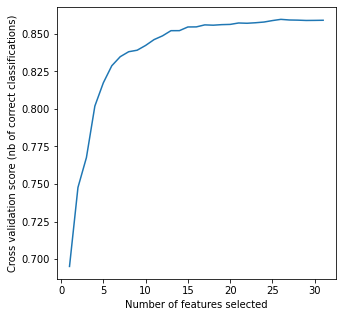

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.grid_scores_

array([0.69512993, 0.74772   , 0.76761542, 0.80193952, 0.81739329,
       0.82874705, 0.8347918 , 0.83810336, 0.83910203, 0.84228219,
       0.84617198, 0.84866862, 0.85211148, 0.85213781, 0.85458215,
       0.85463471, 0.8559751 , 0.85576482, 0.85613284, 0.85629054,
       0.85723663, 0.8570527 , 0.85739439, 0.85786746, 0.85883989,
       0.85965465, 0.85923411, 0.85912897, 0.85891868, 0.85897122,
       0.85905013])

In [ ]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False,  True])

In [ ]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 5, 3, 4, 6, 1])

In [ ]:
print(X_train.columns.values[rfecv.support_])

['url_count' 'qn_symbol' 'num_chars' 'num_words' 'num_sentences'
 'words_per_sentence' 'characters_per_word' 'punctuations_per_sentence'
 'num_exclamation' 'get_sentiment_polarity' 'lexical_diversity'
 'content_word_diversity' 'redundancy' 'noun' 'verb' 'adv'
 'qn_symbol_per_sentence' 'num_exclamation_per_sentence'
 'url_count_per_sentence' 'fake_score' 'true_score' 'common_score' 'anger'
 'anticipation' 'disgust' 'trust']


In [ ]:
rfecv.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [ ]:
rfecv_features

['url_count',
 'qn_symbol',
 'num_chars',
 'num_words',
 'num_sentences',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'num_exclamation',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence',
 'url_count_per_sentence',
 'fake_score',
 'true_score',
 'common_score',
 'anger',
 'anticipation',
 'disgust',
 'trust']

In [ ]:
len(rfecv_features)

26

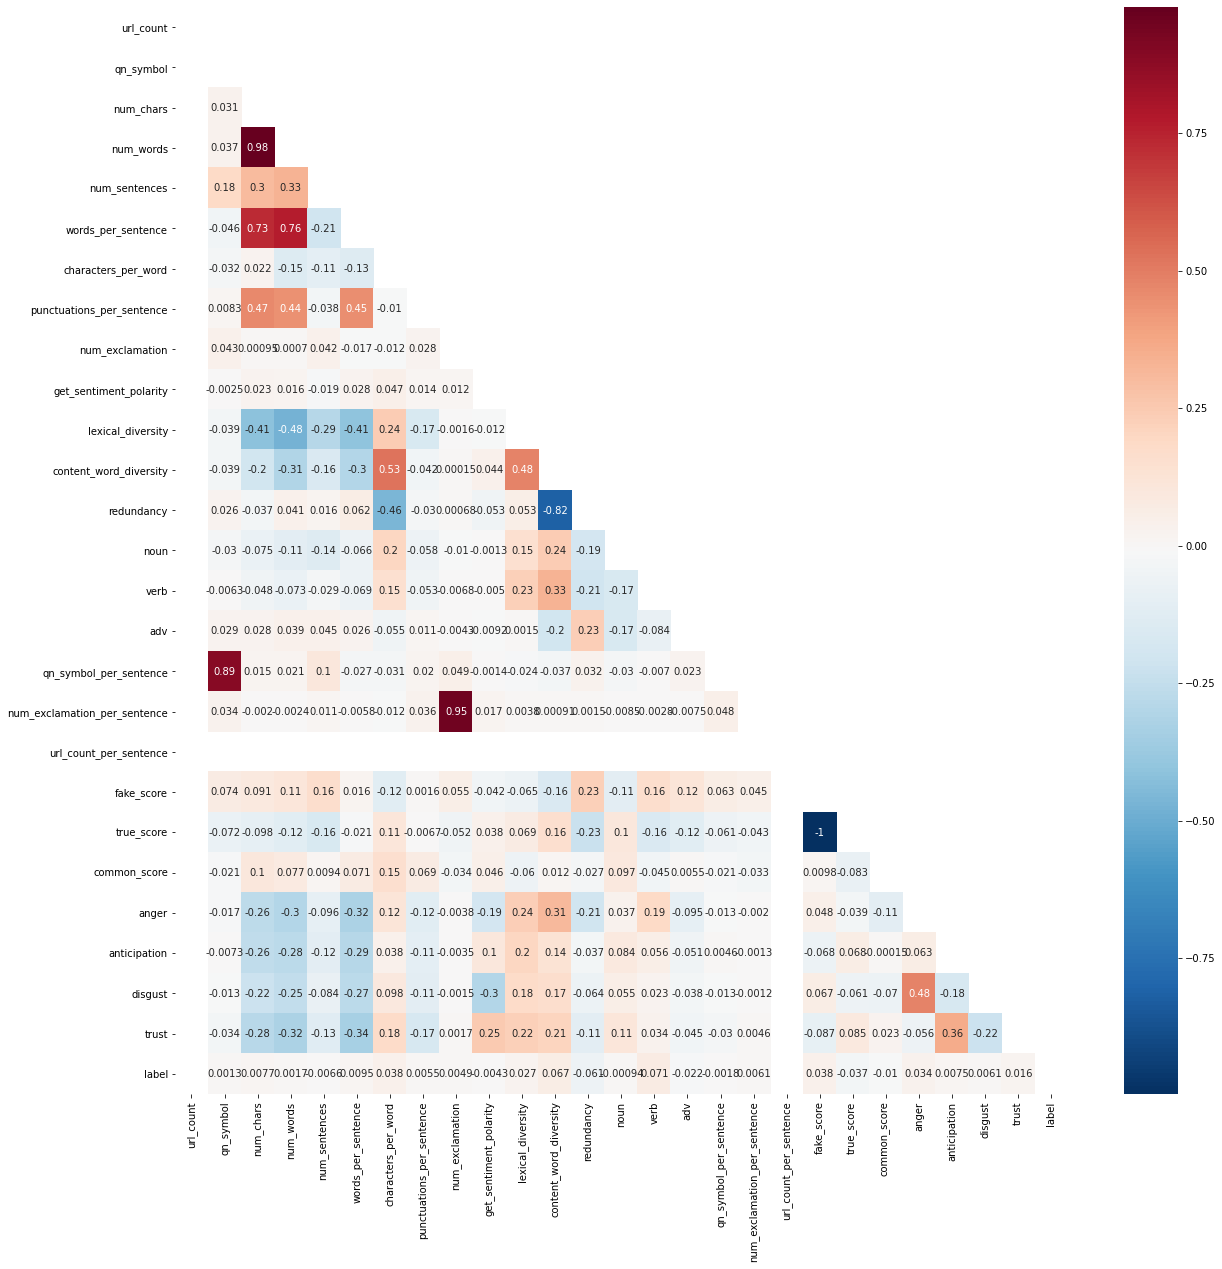

In [ ]:
# mask out upper triangle
mask = np.zeros_like(df[rfecv_features+["label"]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(df[rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
# tn, fp, fn, tp = 0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.862	0.861	0.886	0.833	0.874	0.847	0.861	7809	1006	1254	6238


# XG BOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=14), n_estimators=100,algorithm="SAMME.R", learning_rate=0.0001)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=14,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [ ]:
from sklearn import metrics
predicted_y = ada_clf.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.390	0.666	0.376	0.679	0.383	0.673	0.572	506	838	790	1672


In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	
# 	0.173	0.242	  0.161	0.276	0.167	0.258	0.215

# compare different models Liar 2:4  sementic +sentiment + lang MOd

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
classifiers=[['Logistic Regression :',LogisticRegression()],
       ['Decision Tree Classification :',DecisionTreeClassifier()],
       ['Gradient Boosting Classification :', GradientBoostingClassifier()],
       ['Ada Boosting Classification :',AdaBoostClassifier()],
       ['Extra Tree Classification :', ExtraTreesClassifier()],
       ['K-Neighbors Classification :',KNeighborsClassifier()],
       ['Support Vector Classification :',SVC()],
       ['Gaussian Naive Bayes :',GaussianNB()]]
cla_pred=[]

In [ ]:
# ~ 4-5 min run 
for name,model1 in classifiers:
    print("-----------"+name+"-------------")
    model1.fit(X_train,y_train)
    predicted_y = model1.predict(X_val)
    score=compute_metrics(predicted_y,y_val)
    cla_pred.append(score)

-----------Logistic Regression :-------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


-----------Decision Tree Classification :-------------
-----------Gradient Boosting Classification :-------------
-----------Ada Boosting Classification :-------------
-----------Extra Tree Classification :-------------
-----------K-Neighbors Classification :-------------
-----------Support Vector Classification :-------------
-----------Gaussian Naive Bayes :-------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Y.value_counts()

1    8205
0    4481
Name: label, dtype: int64

'Logistic Regression :'

In [ ]:
#Prining the evaluation matrix to the console
print("Summary\n Class 0- True news \n Class 1 - False news\n")
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"model"))  # correct
for i in range(len(classifiers)):
  # print("-----------"+classifiers[i][0]+"-------------")
  d=cla_pred[i]
  tn, fp, fn, tp = cla_pred[i]["confusiton_mat"].ravel() #correct
  print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,classifiers[i][0]))

Summary
 Class 0- True news 
 Class 1 - False news

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	model
0.430	0.649	0.028	0.980	0.052	0.781	0.644	37	1307	49	2413	Logistic Regression :
0.375	0.659	0.379	0.656	0.377	0.657	0.558	509	835	848	1614	Decision Tree Classification :
0.481	0.657	0.103	0.939	0.170	0.773	0.644	139	1205	150	2312	Gradient Boosting Classification :
0.475	0.662	0.149	0.910	0.227	0.767	0.641	200	1144	221	2241	Ada Boosting Classification :
0.472	0.660	0.130	0.920	0.204	0.769	0.641	175	1169	196	2266	Extra Tree Classification :
0.370	0.653	0.262	0.757	0.307	0.701	0.582	352	992	599	1863	K-Neighbors Classification :
0.000	0.647	0.000	1.000	0.000	0.786	0.647	0	1344	0	2462	Support Vector Classification :
0.379	0.707	0.753	0.326	0.504	0.446	0.477	1012	332	1659	803	Gaussian Naive Bayes :


In [ ]:
# -----------Decision Tree Classification :-------------
# -----------Gradient Boosting Classification :-------------
# -----------Ada Boosting Classification :-------------
# -----------Extra Tree Classification :-------------
# -----------K-Neighbors Classification :-------------
# -----------Support Vector Classification :-------------
# -----------Gaussian Naive Bayes :-------------

# compare different models Liar 1:5  sementic +sentiment + lang MOd

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
classifiers=[['Logistic Regression :',LogisticRegression()],
       ['Decision Tree Classification :',DecisionTreeClassifier()],
       ['Gradient Boosting Classification :', GradientBoostingClassifier()],
       ['Ada Boosting Classification :',AdaBoostClassifier()],
       ['Extra Tree Classification :', ExtraTreesClassifier()],
       ['K-Neighbors Classification :',KNeighborsClassifier()],
       ['Support Vector Classification :',SVC()],
       ['Gaussian Naive Bayes :',GaussianNB()]]
cla_pred=[]

In [ ]:
# ~ 4-5 min run 
for name,model1 in classifiers:
    print("-----------"+name+"-------------")
    model1.fit(X_train,y_train)
    predicted_y = model1.predict(X_val)
    score=compute_metrics(predicted_y,y_val)
    cla_pred.append(score)

-----------Logistic Regression :-------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------Decision Tree Classification :-------------
-----------Gradient Boosting Classification :-------------
-----------Ada Boosting Classification :-------------
-----------Extra Tree Classification :-------------
-----------K-Neighbors Classification :-------------
-----------Support Vector Classification :-------------
-----------Gaussian Naive Bayes :-------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Y.value_counts()

1    10646
0     2040
Name: label, dtype: int64

In [ ]:
#Prining the evaluation matrix to the console
print("Summary\n Class 0- True news \n Class 1 - False news\n")
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"model"))  # correct
for i in range(len(classifiers)):
  # print("-----------"+classifiers[i][0]+"-------------")
  d=cla_pred[i]
  tn, fp, fn, tp = cla_pred[i]["confusiton_mat"].ravel() #correct
  print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,classifiers[i][0]))

Summary
 Class 0- True news 
 Class 1 - False news

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	model
0.000	0.839	0.000	1.000	0.000	0.913	0.839	0	612	0	3194	Logistic Regression :
0.198	0.847	0.204	0.842	0.201	0.844	0.739	125	487	506	2688	Decision Tree Classification :
0.111	0.839	0.002	0.997	0.003	0.911	0.837	1	611	8	3186	Gradient Boosting Classification :
0.333	0.839	0.003	0.999	0.006	0.912	0.839	2	610	4	3190	Ada Boosting Classification :
0.500	0.839	0.002	1.000	0.003	0.913	0.839	1	611	1	3193	Extra Tree Classification :
0.172	0.840	0.038	0.965	0.062	0.898	0.816	23	589	111	3083	K-Neighbors Classification :
0.000	0.839	0.000	1.000	0.000	0.913	0.839	0	612	0	3194	Support Vector Classification :
0.156	0.839	0.046	0.952	0.071	0.892	0.807	28	584	152	3042	Gaussian Naive Bayes :


In [ ]:
# -----------Decision Tree Classification :-------------
# -----------Gradient Boosting Classification :-------------
# -----------Ada Boosting Classification :-------------
# -----------Extra Tree Classification :-------------
# -----------K-Neighbors Classification :-------------
# -----------Support Vector Classification :-------------
# -----------Gaussian Naive Bayes :-------------

# compare different models Welfake  sementic +sentiment + lang MOd

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
classifiers=[['Logistic Regression :',LogisticRegression()],
       ['Decision Tree Classification :',DecisionTreeClassifier()],
       ['Gradient Boosting Classification :', GradientBoostingClassifier()],
       ['Ada Boosting Classification :',AdaBoostClassifier()],
       ['Extra Tree Classification :', ExtraTreesClassifier()],
       ['K-Neighbors Classification :',KNeighborsClassifier()],
       ['Support Vector Classification :',SVC()],
       ['Gaussian Naive Bayes :',GaussianNB()]]
cla_pred=[]

In [ ]:
# ~ 4-5 min run 
for name,model1 in classifiers:
    print("-----------"+name+"-------------")
    model1.fit(X_train,y_train)
    predicted_y = model1.predict(X_val)
    score=compute_metrics(predicted_y,y_val)
    cla_pred.append(score)

-----------Logistic Regression :-------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


-----------Decision Tree Classification :-------------
-----------Gradient Boosting Classification :-------------
-----------Ada Boosting Classification :-------------
-----------Extra Tree Classification :-------------
-----------K-Neighbors Classification :-------------
-----------Support Vector Classification :-------------
-----------Gaussian Naive Bayes :-------------


In [ ]:
Y.value_counts()

0    29382
1    24974
Name: label, dtype: int64

In [ ]:
#Prining the evaluation matrix to the console
print("Summary\n Class 0- True news \n Class 1 - False news\n")
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"model"))  # correct
for i in range(len(classifiers)):
  # print("-----------"+classifiers[i][0]+"-------------")
  d=cla_pred[i]
  tn, fp, fn, tp = cla_pred[i]["confusiton_mat"].ravel() #correct
  print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,classifiers[i][0]))

Summary
 Class 0- True news 
 Class 1 - False news

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	model
0.765	0.767	0.818	0.705	0.791	0.735	0.766	7214	1601	2212	5280	Logistic Regression :
0.813	0.771	0.803	0.783	0.808	0.777	0.793	7075	1740	1628	5864	Decision Tree Classification :
0.854	0.868	0.894	0.821	0.874	0.844	0.860	7879	936	1342	6150	Gradient Boosting Classification :
0.837	0.849	0.879	0.798	0.857	0.823	0.842	7749	1066	1510	5982	Ada Boosting Classification :
0.864	0.876	0.900	0.833	0.882	0.854	0.869	7932	883	1249	6243	Extra Tree Classification :
0.735	0.770	0.836	0.645	0.782	0.702	0.748	7370	1445	2660	4832	K-Neighbors Classification :
0.670	0.664	0.758	0.561	0.712	0.608	0.668	6685	2130	3288	4204	Support Vector Classification :
0.624	0.883	0.964	0.317	0.758	0.466	0.667	8501	314	5118	2374	Gaussian Naive Bayes :


In [ ]:
# -----------Decision Tree Classification :-------------
# -----------Gradient Boosting Classification :-------------
# -----------Ada Boosting Classification :-------------
# -----------Extra Tree Classification :-------------
# -----------K-Neighbors Classification :-------------
# -----------Support Vector Classification :-------------
# -----------Gaussian Naive Bayes :-------------

# TPOT


In [ ]:
# http://epistasislab.github.io/tpot/using/

In [ ]:
!pip install TPOT -q

     |████████████████████████████████| 87 kB 3.6 MB/s 
     |████████████████████████████████| 166.7 MB 7.3 kB/s 
     |████████████████████████████████| 160 kB 64.7 MB/s 


In [ ]:
from tpot import TPOTClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Create a tpot optimizer with parameters
tpot = TPOTClassifier(scoring = 'accuracy', 
                      config_dict='TPOT light' ,
                    #  max_time_mins = 60, 
                     n_jobs = -1,
                     verbosity = 2,
                     periodic_checkpoint_folder="/content/drive/Shareddrives/[FYP] Fake News Detection/Feature Fusion/tPOT",
                    # memory="auto"
                    )

In [ ]:
tpot.fit(X_train,y_train)

In [ ]:
# Best pipeline: KNeighborsClassifier(MultinomialNB(MinMaxScaler(input_matrix), alpha=0.001, fit_prior=True), n_neighbors=78, p=2, weights=distance)
# TPOTClassifier(config_dict='TPOT light', crossover_rate=0.1, cv=5,
#                disable_update_check=False, early_stop=None, generations=100,
#                log_file=None, max_eval_time_mins=5, max_time_mins=60,
#                memory=None, mutation_rate=0.9, n_jobs=-1, offspring_size=None,
#                periodic_checkpoint_folder='/content/drive/Shareddrives/[FYP] '
#                                           'Fake News Detection/Feature '
#                                           'Fusion/tPOT',
#                population_size=100, random_state=None, scoring='accuracy',
#                subsample=1.0, template=None, use_dask=False, verbosity=2,
#                warm_start=False)

# 63

In [ ]:
# Export the pipeline as a python script file
tpot.export('/content/drive/Shareddrives/[FYP] Fake News Detection/Feature Fusion/tPOT/tpot_exported_pipeline1.py')

In [ ]:
tpot.score(X_val, y_val)

## tPot KNeighborsClassifier Welfake  sementic +sentiment + lang MOd

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, make_union
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from sklearn.neighbors import KNeighborsClassifier
exported_pipeline = make_pipeline(
    make_union(
        VarianceThreshold(threshold=0.01),
        FunctionTransformer(copy)
    ),
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=86, p=2, weights="distance")
)

In [ ]:
exported_pipeline.fit(X_train,y_train)
results = exported_pipeline.predict(X_val)

In [ ]:
X_train.shape

(38049, 31)

In [ ]:
gg=compute_metrics(results,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
# tn, fp, fn, tp = 0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.746	0.884	0.930	0.628	0.828	0.734	0.791	8195	620	2786	4706


## tPot KNeighborsClassifier Liar 1:5   sementic +sentiment + lang MOd

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, make_union
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from sklearn.neighbors import KNeighborsClassifier
exported_pipeline = make_pipeline(
    make_union(
        VarianceThreshold(threshold=0.01),
        FunctionTransformer(copy)
    ),
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=86, p=2, weights="distance")
)

In [ ]:
exported_pipeline.fit(X_train,y_train)
results = exported_pipeline.predict(X_val)

In [ ]:
gg=compute_metrics(results,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
# tn, fp, fn, tp = 0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))